# TCAM

### Use $T_s$ trend to calculate all other trends

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
from scipy.interpolate import interp2d
import os
from mpl_toolkits.basemap import Basemap

from cartopy import config
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

# When data are defined in lat/lon coordinate system, PlateCarree()
# is the appropriate choice:

from cartopy.util import add_cyclic_point

## TMDAsolver function

In [2]:
def TDMAsolver(nx, ny, a, b, c, d):
    import numpy as np

    nf = ny  # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d))  # copy arrays

    for it in range(1, nf):
        mc = ac[it, :] / bc[it - 1, :]
        bc[it, :] = bc[it, :] - mc * cc[it - 1, :]
        dc[it, :] = dc[it, :] - mc * dc[it - 1, :]

    xc = bc
    xc[-1, :] = dc[-1, :] / bc[-1, :]

    for il in range(nf - 2, -1, -1):
        xc[il, :] = (dc[il, :] - cc[il, :] * xc[il + 1, :]) / bc[il, :]

    return xc

## Parameter Input

In [3]:
# Make changes here ----------
eps_days = 0.75
K_days = 10
efrac = 2.0  # multiply epsu by efrac to get epsv
Hq = 1800
PrcpLand = 0  # use data precip trends over land

wnspmin = 4
rho00 = 0.3

prmax = 20.0 / 3600 / 24
r = 0.80
nx = 180
ny = 60
YN = 60
YS = -YN

basedir = "tmp/S91"

if not os.path.isdir("tmp"):
    os.makedirs("tmp")

NumberIterations = 50

## Constants Input

In [4]:
gravity = 9.8
ZT = 15000
Th00 = 300
NBSQ = 3.0e-4
rEarth = 6.37e6
omega2 = 2 * (2 * np.pi / 86400)
L = 2.5e6
cpair = 1000

outfile = basedir + "-Hq" + str(Hq) + "-PrcpLand" + str(PrcpLand) + ".nc"
B = gravity * np.pi / (NBSQ * Th00 * ZT)
eps = 1.0 / (eps_days * 86400)
epsu = eps
epsv = efrac * eps
K1 = B / (K_days * 86400)
epsp = (np.pi / ZT) ** 2 / (NBSQ * K_days * 86400)
beta = omega2 / rEarth

# make grids
dx = 360 / nx
dy = (YN - YS) / ny
Yv = np.linspace(YS + dy / 2, YN - dy / 2, ny)
X = np.linspace(0, 360 - dx, nx)
Yu = np.linspace(YS + dy, YN - dy, ny - 1)
Yi = np.linspace(YS + 3 * dy / 2, YN - 3 * dy / 2, ny - 2)
dX = X[1] - X[0]
dY = Yv[1] - Yv[0]
dxm = dX * rEarth * np.pi / 180
dym = dY * rEarth * np.pi / 180
dym2 = dym * dym


def fcor(Y):
    return omega2 * Y * np.pi / 180


fcu = fcor(Yu)

## Make wave number vector

In [5]:
# need to have the correct ordering of the wave numbers for fft
N = nx
if N % 2 == 0:
    Kk = np.asarray(
        list(range(0, N // 2)) + [0] + list(range(-N // 2 + 1, 0)), np.float64
    )
else:
    Kk = np.asarray(
        list(range(0, (N - 1) // 2)) + [0] + list(range(-(N - 1) // 2, 0)), np.float64
    )

## Flux Functions

In [6]:
def f_qa(ts, sp):
    # ts: sst in Kelvin
    # sp: surface pressure in mb
    # return qs: surface specific humidity
    es0 = 6.11
    efac = 0.622
    es = es0 * np.exp(17.67 * (ts - 273.15) / ((ts - 273.15) + 243.5))
    return efac * r * es / sp


def f_qa2(ts):
    # ts: sst in Kelvin
    # return qs: surface specific humidity
    return 0.001 * (ts - 273.15 - 11.0)


def f_E(mask, qa, wnsp):
    # qa: surface air humidity
    # wnsp: surface windspeed in m/s
    # return Evap in kg/m^2/s
    rhoair = 1.225
    CsE = 0.0015 * (1 + mask / 2)
    # CsE = 0.0012
    return CsE * rhoair * (1 - r) * qa * wnsp / r


def f_MC(qa, u, v):
    from scipy.fftpack import fft, ifft

    # qa: surface air humidity
    # u,v: low level winds in m/s (N.B., v is on Yv points, u,q are on Yu points)
    # return Moisture Convergence in kg/m^2/s
    rhoair = 1.225
    qu = qa * u
    qux = ifft(1.0j * Kk * fft(qu) / rEarth).real
    Aq = (qa[1 : ny - 1, :] + qa[0 : ny - 2, :]) / 2.0
    qv = Aq * v[1 : ny - 1, :]
    z = np.zeros((1, nx))
    qv = np.concatenate((z, qv, z), axis=0)
    # qvy = qv.diff('Yu')/dym
    qvy = (qv[1:ny, :] - qv[0 : ny - 1, :]) / dym
    return -Hq * (qux + qvy) * rhoair

## S91_solver function - solve in wavespace?

In [7]:
def S91_solver(Q1):
    from scipy.fftpack import fft, ifft

    Q1t = fft(Q1)
    fQ = fcu[:, np.newaxis] * Q1t
    AfQ = (fQ[1 : ny - 1, :] + fQ[0 : ny - 2, :]) / 2.0
    km = Kk / rEarth
    DQ = (Q1t[1 : ny - 1, :] - Q1t[0 : ny - 2, :]) / dym
    rk = 1.0j * km * beta - epsu * epsv * epsp - epsv * km ** 2
    fcp = fcu[1 : ny - 1] ** 2 / 4.0
    fcm = fcu[0 : ny - 2] ** 2 / 4.0

    ak = epsu / dym2 - epsp * fcm[:, np.newaxis]
    ck = epsu / dym2 - epsp * fcp[:, np.newaxis]
    bk = (
        -2 * epsu / dym2
        - epsp * (fcm[:, np.newaxis] + fcp[:, np.newaxis])
        + rk[np.newaxis, :]
    )
    dk = -epsu * DQ + 1.0j * km[np.newaxis, :] * AfQ

    vtk = TDMAsolver(nx, ny - 2, ak, bk, ck, dk)

    z = np.zeros((1, nx))
    vt = np.concatenate((z, vtk, z), axis=0)
    Av = (vt[1:ny, :] + vt[0 : ny - 1, :]) / 2.0
    fAv = fcu[:, np.newaxis] * Av
    Dv = (vt[1:ny, :] - vt[0 : ny - 1, :]) / dym
    coeff = epsu * epsp + km * km
    ut = (epsp * fAv + 1.0j * (Q1t + Dv) * km[np.newaxis, :]) / coeff[np.newaxis, :]
    phit = -(Q1t + 1.0j * ut * km[np.newaxis, :] + Dv) / epsp
    v = ifft(vt).real
    u = ifft(ut).real
    phi = ifft(phit).real
    return (u, v, phi)

## smooth121 function 

In [8]:
def smooth121(da, sdims, NSmooths=1, perdims=[]):
    """Applies [0.25, 0.5, 0.25] stencil in sdims, one at a time
    Usage
    -----
    Smooth121(DataArray,list1,Nsmooths=int1,perdims=list2)
        name : xarray.DataArray - e.g., ds.var
        list1: list of dimensions over which to smooth - e.g., ['lat','lon']
        int1 : integer number of smooths to apply - e.g., 1
        list2: list of dimension to be treated as period boundaries - e.g., ['lon']

    Example
    -------
        smooth_var = smooth121(ds.var, ['lon', 'lat], NSmooths = 2, perdims = ['lon'])
    """
    mask = da.notnull()
    weight = xr.DataArray([0.25, 0.5, 0.25], dims=["window"])
    v = da.copy()
    origdims = v.dims

    for dim in sdims:
        for smooth in range(0, NSmooths):
            if dim in perdims:
                v0 = xr.concat([v.isel(**{dim: -1}), v, v.isel(**{dim: 0})], dim=dim)
            else:
                v0 = xr.concat([v.isel(**{dim: 0}), v, v.isel(**{dim: -1})], dim=dim)
            v1 = v0.bfill(dim, limit=1)
            v0 = v1.ffill(dim, limit=1)
            v1 = v0.rolling(**{dim: 3}, center=True).construct("window").dot(weight)
            v = v1.isel(**{dim: slice(1, -1, None)})

    return v.where(mask, np.nan).transpose(*origdims)

## Output Dataset & some plots

In [9]:
# Define the new Dataset
ds = xr.Dataset({"X": ("X", X), "Yu": ("Yu", Yu), "Yv": ("Yv", Yv)})
ds.X.attrs = [("units", "degree_east")]
ds.Yu.attrs = [("units", "degree_north")]
ds.Yv.attrs = [("units", "degree_north")]

ds["K"] = K_days
ds.K.attrs = [("units", "day")]
ds["epsu"] = eps_days
ds.epsu.attrs = [("units", "day")]
ds["epsv"] = eps_days / efrac
ds.epsv.attrs = [("units", "day")]
ds["Hq"] = Hq
ds.Hq.attrs = [("units", "m")]

In [10]:
# CLIMATOLOGIES

dsClim = xr.open_dataset("DATA/sfcWind-ECMWF-clim.nc")
fwnsp = interp2d(dsClim.X, dsClim.Y, dsClim.sfcWind, kind="linear")
dsClim = xr.open_dataset("DATA/ts-ECMWF-clim.nc")
fts = interp2d(dsClim.X, dsClim.Y, dsClim.ts, kind="linear")
dsClim = xr.open_dataset("DATA/pr-ECMWF-clim.nc")
fpr = interp2d(dsClim.X, dsClim.Y, dsClim.pr, kind="linear")
dsClim = xr.open_dataset("DATA/ps-ECMWF-clim.nc")
fsp = interp2d(dsClim.X, dsClim.Y, dsClim.ps, kind="linear")

wnsp = fwnsp(X, Yu)
wnsp[wnsp < wnspmin] = wnspmin
ds["wnspClim"] = (["Yu", "X"], wnsp)
ds["tsClim"] = (["Yu", "X"], fts(X, Yu))
ds["prClim"] = (["Yu", "X"], fpr(X, Yu))
ds["spClim"] = (["Yu", "X"], fsp(X, Yu))

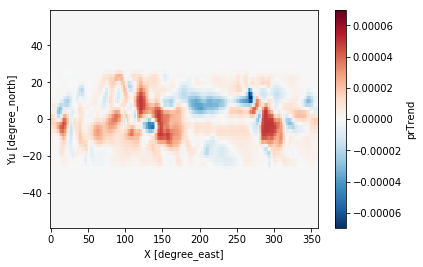

In [11]:
# TRENDS
dsTrend = xr.open_dataset("DATA/ts-ECMWF-trend.nc")
ftsTrend = interp2d(dsTrend.X, dsTrend.Y, dsTrend.ts, kind="linear")
dsTrend = xr.open_dataset("DATA/pr-ECMWF-trend.nc")
fprTrend = interp2d(dsTrend.X, dsTrend.Y, dsTrend.pr, kind="linear")

tsTrend = ftsTrend(X, Yu)
ds["tsTrend"] = (["Yu", "X"], tsTrend)

prTrend = fprTrend(X, Yu)
prTrend[abs(Yu) > 25] = 0
prTrend[prTrend > 5e-5] = 5e-5
ds["prTrend"] = (["Yu", "X"], prTrend)
ds["prTrend"] = smooth121(ds.prTrend, ["Yu", "X"], perdims=["X"])

ds.prTrend.plot()

In [12]:
dsmask = xr.open_dataset("DATA/mask-360x180.nc")
fmask = interp2d(dsmask.X, dsmask.Y, 0 * dsmask.mask, kind="linear")
ds["mask"] = (["Yu", "X"], fmask(X, Yu))

tsClim = ds.tsClim.values
spClim = ds.spClim.values
wnspClim = ds.wnspClim.values
wnspClim[wnspClim < wnspmin] = wnspmin
mask = ds.mask.values
wend = wnspClim
wbeg = wnspClim

In [13]:
tsend = (ds.tsClim + (1 - mask) * ds.tsTrend / 2).values
tsbeg = (ds.tsClim - (1 - mask) * ds.tsTrend / 2).values
prend = (ds.prClim + ds.prTrend / 2).values
prbeg = (ds.prClim - ds.prTrend / 2).values
Qthend = K1 * (tsend - 30) / B
Qthbeg = K1 * (tsbeg - 30) / B

qaend = f_qa(tsend, spClim)
Eend = f_E(mask, qaend, wnspClim)
PRend = Eend
PRend[PRend < 0] = 0

qabeg = f_qa(tsbeg, spClim)
Ebeg = f_E(mask, qabeg, wnspClim)
PRbeg = Ebeg
PRbeg[PRbeg < 0] = 0

In [14]:
Qth = Qthend
PR = PRend
E1 = Eend
qa1 = qaend

# Find total PR, u and v at end
for repeat in range(0, NumberIterations):
    # Start main calculation
    Qc = np.pi * L * PR / (2 * cpair * rho00 * ZT)  # heating from precip
    Q1 = B * (Qc + Qth)
    (u1, v1, phi1) = S91_solver(Q1)
    daMC = xr.DataArray(f_MC(qa1, u1, v1), dims=["Yu", "X"])
    MC1 = smooth121(daMC, ["Yu", "X"], perdims=["X"]).values
    if PrcpLand:
        PR = (1 - mask) * (MC1 + E1) + mask * prend
    else:
        PR = (1 - mask) * (MC1 + E1)
    PR[PR < 0] = 0
    # PR[PR > prmax] = prmax

MCend = MC1
uend = u1
vend = v1
phiend = phi1
PRend = PR

In [15]:
Qth = Qthbeg
PR = PRbeg
E1 = Ebeg
qa1 = qabeg

# Find total PR, u and v at beginning
for repeat in range(0, NumberIterations):
    # Start main calculation
    Qc = np.pi * L * PR / (2 * cpair * rho00 * ZT)  # heating from precip
    Q1 = B * (Qc + Qth)
    (u1, v1, phi1) = S91_solver(Q1)
    daMC = xr.DataArray(f_MC(qa1, u1, v1), dims=["Yu", "X"])
    MC1 = smooth121(daMC, ["Yu", "X"], perdims=["X"]).values
    if PrcpLand:
        PR = (1 - mask) * (MC1 + E1) + mask * prbeg
    else:
        PR = (1 - mask) * (MC1 + E1)
    PR[PR < 0] = 0
    # PR[PR > prmax] = prmax

MCbeg = MC1
ubeg = u1
vbeg = v1
phibeg = phi1
PRbeg = PR

In [16]:
# save and plot the trends
ds["utrend"] = (["Yu", "X"], uend - ubeg)
ds["vtrend"] = (["Yv", "X"], vend - vbeg)
ds["phitrend"] = (["Yu", "X"], phiend - phibeg)
ds["tstrend"] = (["Yu", "X"], tsend - tsbeg)
ds["PRtrend"] = (["Yu", "X"], PRend - PRbeg)
ds["Qthtrend"] = (["Yu", "X"], Qthend - Qthbeg)

ds["uend"] = (["Yu", "X"], uend)
ds["vend"] = (["Yv", "X"], vend)
ds["wend"] = (["Yu", "X"], wend)
ds["phiend"] = (["Yu", "X"], phiend)
ds["tsend"] = (["Yu", "X"], tsend)
ds["PRend"] = (["Yu", "X"], PRend)
ds["Qthend"] = (["Yu", "X"], Qthend)
ds["Eend"] = (["Yu", "X"], Eend)
ds["MCend"] = (["Yu", "X"], MCend)
ds["qaend"] = (["Yu", "X"], qaend)

ds["ubeg"] = (["Yu", "X"], ubeg)
ds["vbeg"] = (["Yv", "X"], vbeg)
ds["wbeg"] = (["Yu", "X"], wbeg)
ds["phibeg"] = (["Yu", "X"], phibeg)
ds["tsbeg"] = (["Yu", "X"], tsbeg)
ds["PRbeg"] = (["Yu", "X"], PRbeg)
ds["Qthbeg"] = (["Yu", "X"], Qthbeg)
ds["Ebeg"] = (["Yu", "X"], Ebeg)
ds["MCbeg"] = (["Yu", "X"], MCbeg)
ds["qabeg"] = (["Yu", "X"], qabeg)

# There is 2 gridpoint noise in the phi field - so add a smooth in X:
ds["phitrend"] = smooth121(ds.phitrend, ["X"], NSmooths=1, perdims=["X"])

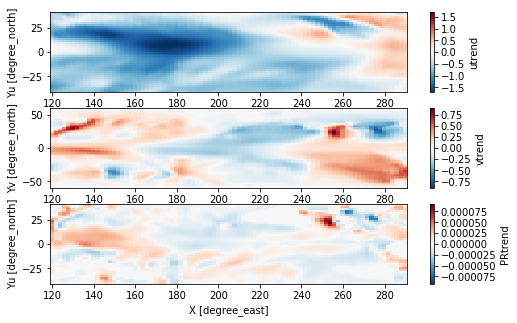

In [17]:
ds_subset = ds.sel(X=slice(120, 290), Yu=slice(-40, 40))

plt.figure(figsize=(8, 5))
plt.subplot(311)
ds_subset.utrend.plot(cmap="RdBu_r")
plt.subplot(312)
ds_subset.vtrend.plot(cmap="RdBu_r")
plt.subplot(313)
ds_subset.PRtrend.plot(cmap="RdBu_r")
# plt.savefig('S90-H2000-Stab.eps', format='eps', dpi=1000)

In [18]:
ds.utrend.attrs = [("units", "m/s")]
ds.vtrend.attrs = [("units", "m/s")]
ds.phitrend.attrs = [("units", "m2/s2")]
ds.PRtrend.attrs = [("units", "m/s")]
ds.Qthtrend.attrs = [("units", "K/s")]

print(outfile)
dict = {
    "K": {"dtype": "f4"},
    "epsu": {"dtype": "f4"},
    "epsv": {"dtype": "f4"},
    "Hq": {"dtype": "f4"},
}
ds.to_netcdf(outfile, encoding=dict)

tmp/S91-Hq1800-PrcpLand0.nc


## Plot trends

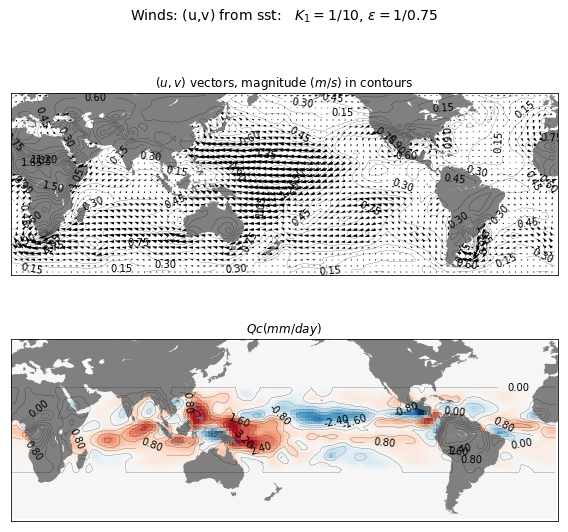

In [19]:
m = Basemap(
    projection="cyl",
    llcrnrlat=-60,
    urcrnrlat=60,
    llcrnrlon=0,
    urcrnrlon=360,
    resolution="c",
)
import warnings

ftitle = (
    "Winds: (u,v) from sst: "
    + "  $K_1=1/"
    + str(K_days)
    + "$, $\epsilon=1/"
    + str(eps_days)
    + "$"
)
warnings.filterwarnings("ignore")
DoPlot = True
v = ds.vtrend.values
u = ds.utrend.values
Q = ds.prTrend.values
if DoPlot:
    nsy = 2  # plot every nsy grid point
    nsx = nsy
    plt.figure(figsize=(8, 8))
    plt.suptitle(ftitle, size=14)
    plt.subplot(211)
    plt.title(r"$(u,v)$ vectors, magnitude ($m/s$) in contours")
    m.fillcontinents(color="grey")
    Av = np.squeeze(v[1:ny, :] + v[0 : ny - 1, :]) / 2.0
    Au = np.squeeze(u[:, :])
    AQ = np.squeeze(Q[:, :])
    mag = np.sqrt(Au * Au + Av * Av)

    CS = plt.contour(X, Yu, mag, 15, colors="k", linewidths=0.2, vmin=0, vmax=10)
    plt.clabel(CS, inline=1, fontsize=10, fmt="%.2f")
    # CS=plt.contour(X2,Yu,mag,5,linewidths=1)
    # plt.clabel(CS, inline=1, fontsize=10,fmt='%.1f')
    # print(np.shape(Au[::nsy,::nsx]),np.shape(Av[::nsy,::nsx]))
    m.quiver(X[::nsx], Yu[::nsy], Au[::nsy, ::nsx], Av[::nsy, ::nsx], scale=75)
    plt.subplot(212)
    plt.title(r"$Qc (mm/day)$")
    m.fillcontinents(color="grey")
    m.pcolormesh(X, Yu, 24 * 3600 * AQ, cmap="RdBu_r", vmin=-5, vmax=5)
    CS = plt.contour(
        X, Yu, 24 * 3600 * AQ, 15, colors="k", linewidths=0.2, vmin=-20, vmax=20
    )
    plt.clabel(CS, inline=1, fontsize=10, fmt="%.2f")
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.savefig(
        "windsFromSST-K" + str(K_days) + "-eps" + str(eps_days) + ".eps",
        format="eps",
        dpi=1000,
    )

/home/naomi/.conda/envs/my3.6/lib/python3.6/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


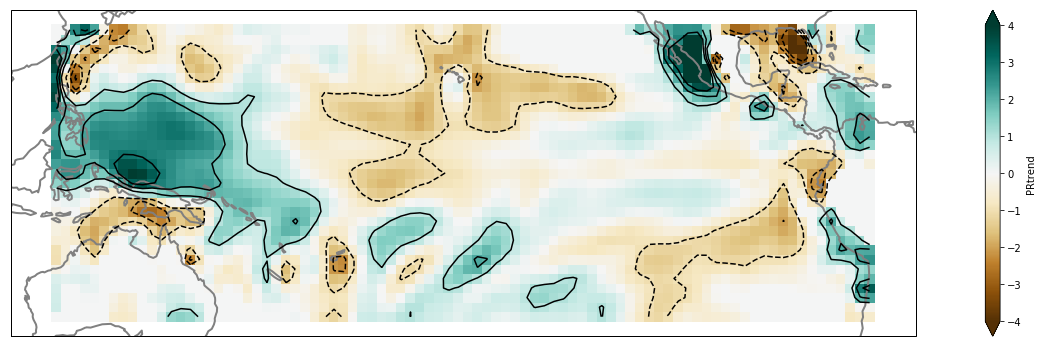

In [20]:
proj = ccrs.PlateCarree(central_longitude=200)
trans = ccrs.PlateCarree()

pr = (ds.PRtrend.sel(X=slice(120, 290), Yu=slice(-30, 30))) * 3600 * 24
plt.figure(figsize=(25, 6))
ax2 = plt.axes(projection=proj)
pr.plot(ax=ax2, transform=trans, cmap="BrBG", vmin=-4, vmax=4)
ax2.coastlines(lw=2, color="grey")

CS1 = pr.plot.contour(
    ax=ax2,
    transform=trans,
    levels=[-3, -2, -1, 1, 2, 3],
    colors="black",
    #                                             linestyles='solid',
    #                                              add_colorbar=True,
    add_labels=True,
    zorder=5,
)